In [99]:
import pandas as pd
import numpy as np

In [100]:
df = pd.read_csv('datasets/diabetes.csv')

# separate features & outcomes
x = df.drop(columns=['Outcome'])
y = df['Outcome']

In [101]:
# Build a pipeline function to make pre-processing easier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_absolute_error,mean_squared_error
import joblib

def data_split_standardise(x,y=None):
    if y is None:
        st=StandardScaler()
        st.fit(x)
        x_std=st.transform(x)
        joblib.dump(st,"StandardScalar_trained.h5")
        return(x_std)
    else:

        
        
        
        x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)
        st=StandardScaler()
        st.fit(x_train)
        x_train_std=st.transform(x_train)
        x_test_std=st.transform(x_test)
        joblib.dump(st,"StandardScalar_trained.h5")    
        return(x_train_std,x_test_std,y_train,y_test)

In [102]:
x_train_std, x_test_std, y_train, y_test = data_split_standardise(x,y)

In [103]:
# import PyTorch & related dependencies

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [104]:
# Define a network - this is handled in Keras with the Sequential() function
class Model(nn.Module):
    
    # Initialize model structure
    def __init__(self,input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,50)
        self.layer2 = nn.Linear(50,50)
        self.layer3 = nn.Linear(50,3)
        
    # Logic for forward propagation
    def forward(self, x):
        x = F.relu(self.layer1(x)) # important that you apply these layers to the input (and each successive step)
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1) # calc softmax along axis 1
        return(x)

In [105]:
# Complile options
model = Model(x_train_std.shape[1])
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [106]:
# Print Model Structure
model

Model(
  (layer1): Linear(in_features=8, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [107]:
import tqdm # visualization library for PyTorch

In [108]:
# Set up hyperparams
EPOCHS = 200
# Need to convert our input data into Torch objects
x_train = Variable(torch.from_numpy(x_train_std)).float()
x_test = Variable(torch.from_numpy(x_test_std)).float()
y_train = Variable(torch.from_numpy(np.array(y_train))).long() # long --> integer
y_test = Variable(torch.from_numpy(np.array(y_test))).long()


In [109]:
loss_list = []
accuracy_list_test = []
accuracy_list_train = []

In [111]:
# Iterate over epochs for each pass of the network
for epoch in tqdm.trange(EPOCHS):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    loss_list.append(loss.item())
    correct_train = (torch.argmax(y_pred,dim=1)==y_train).type(torch.FloatTensor)
    accuracy_list_train.append(correct_train.mean())
    
    # zero-out gradient
    optimizer.zero_grad()
    # backward finds the derivative of the loss function (i.e. the new gradient)
    loss.backward()
    optimizer.step()
    
    # we do not want to calc new gradients on our validation data
    with torch.no_grad():
        y_test_pred = model(x_test)
        correct_test = (torch.argmax(y_test_pred,dim=1)==y_test).type(torch.FloatTensor)
        accuracy_list_test.append(correct_test.mean())

100%|████████████████████████████████████| 200/200 [00:00<00:00, 527.26it/s]


In [112]:
from matplotlib import pyplot as plt

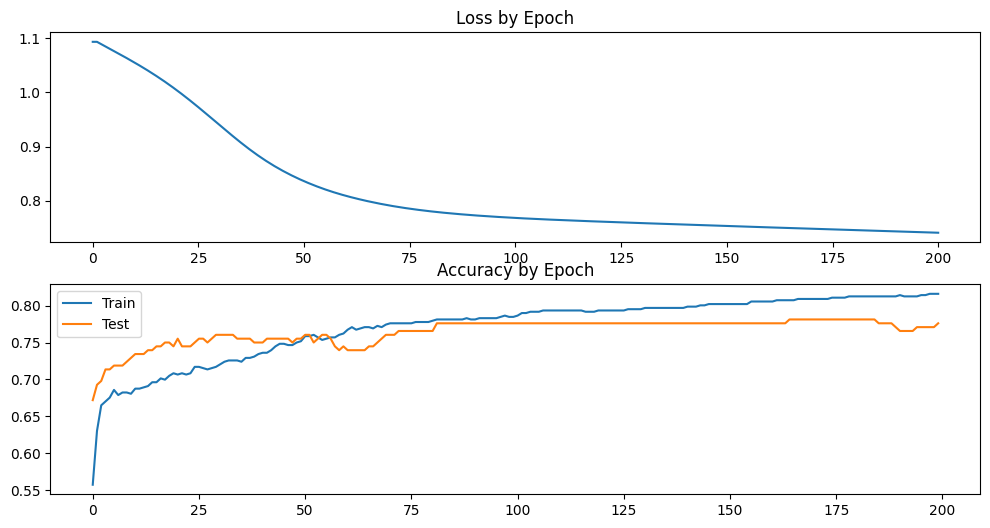

In [113]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(loss_list)
plt.title('Loss by Epoch')

plt.subplot(2,1,2)
plt.plot(accuracy_list_train,label="Train")
plt.plot(accuracy_list_test,label="Test")
plt.title('Accuracy by Epoch')
plt.legend()
plt.show()